### Try It: Comparing Feature Selection Methods

In this module, you have seen two ways to select features.  The first approach is using sequential feature selection to sequentially add or delete features and only use those that improve the model.  The second approach is using a regularized model to identify features based on non-zero coefficients.  This activity focuses on comparing variations of both these methods.  

You will use both the `SequentialFeatureSelection` and `RFE` (recursive feature elimination) to build and compare regression models.  Consider the following 6 feature selection methods -- leave all other arguments to default besides the `estimator` and `n_features_to_select` arguments:

- `Ridge` regressor to extract coefficients
- `SequentialFeatureSelection` using the `Lasso` to select 4 features.
- `RFE` using `Lasso` to select 4 features.

For each of these, fit the training data `X_train`, `y_train` below.  Compare the magnitude of the results of your `Ridge` model to those that result from feature selection methods.  

#### The Data

For this problem a dataset with information on red wine chemical compositions and their quality is given.  Your goal is to use the properties of the wine to predict the quality.  Below, the data is loaded and train/test splits constructed.

In [39]:
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [41]:
df = pd.read_csv('../data/winequality-red.csv', sep = ',')

In [43]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [45]:
X = df.drop('quality', axis = 1)
y = df['quality']

<Axes: >

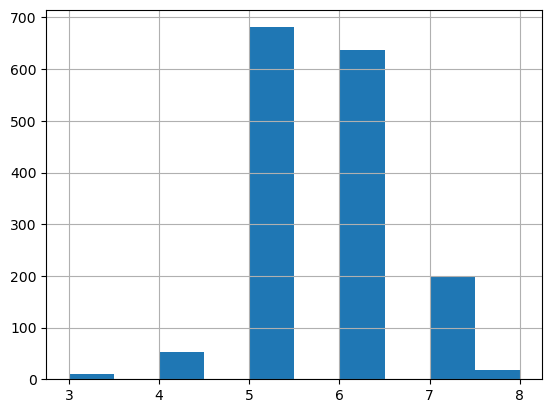

In [47]:
y.hist()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Ridge regressor to extract coefficients (Using GridSearchCV)

In [58]:
ridge_param_dict = {'ridge__alpha': np.logspace(-4, 4, 50)}
ridge_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)

ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)
print('ridge_train_mse:',ridge_train_mse)
print('ridge_test_mse:',ridge_test_mse)

ridge_best_alpha = ridge_grid.best_params_['ridge__alpha']
print('ridge_best_alpha:',ridge_best_alpha)

# Extract the best estimator and its coefficients
best_ridge_model = ridge_grid.best_estimator_
ridge_coef = best_ridge_model.named_steps['ridge'].coef_
print('ridge_coef:',ridge_coef)

ridge_coef_df = pd.DataFrame(zip(X_train.columns, ridge_coef) , columns=['feature', 'ridge_coef'])
ridge_coef_df_sorted = ridge_coef_df.reindex(ridge_coef_df['ridge_coef'].abs().sort_values(ascending=False).index)
print('ridge_coef_df_sorted:')
ridge_coef_df_sorted

ridge_train_mse: 0.42812356456832135
ridge_test_mse: 0.3896302697256314
ridge_best_alpha: 75.43120063354607
ridge_coef: [ 0.04985729 -0.16935326 -0.00715067  0.01823137 -0.0832446   0.04122615
 -0.11156329 -0.05267883 -0.03482946  0.13866633  0.27431721]
ridge_coef_df_sorted:


,feature,ridge_coef
10,alcohol,0.274317
1,volatile acidity,-0.169353
9,sulphates,0.138666
6,total sulfur dioxide,-0.111563
4,chlorides,-0.083245
7,density,-0.052679
0,fixed acidity,0.049857
5,free sulfur dioxide,0.041226
8,pH,-0.034829
3,residual sugar,0.018231


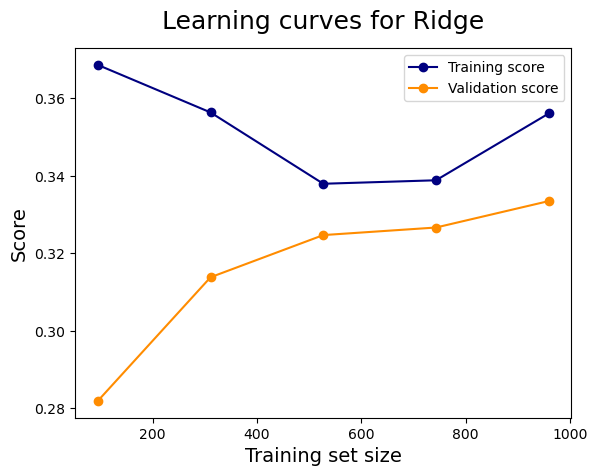

In [89]:
#Plot Learning curve
ridge_train_sizes, ridge_train_scores, ridge_test_scores = learning_curve(
        ridge_grid,
        X_train,
        y_train
    )
ridge_train_scores_mean = np.mean(ridge_train_scores, axis=1)
ridge_test_scores_mean = np.mean(ridge_test_scores, axis=1)

plt.plot(ridge_train_sizes, ridge_train_scores_mean, label="Training score", color="navy", marker='o')
plt.plot(ridge_train_sizes, ridge_test_scores_mean, label="Validation score", color="darkorange", marker='o')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

## SequentialFeatureSelection using the Lasso to select 4 features.

In [62]:
# Finding best Alpha for LASSO model
# Define the parameter grid
lasso_param_grid = {'lasso__alpha': np.logspace(-4, 4, 50)}

# Create a pipeline with a scaler and Lasso regression
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# Perform grid search with cross-validation
lasso_grid_search = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid)
lasso_grid_search.fit(X_train, y_train)

# Get the best alpha
best_alpha_lasso = lasso_grid_search.best_params_['lasso__alpha']

# Print the best alpha
print("Best alpha for Lasso:", best_alpha_lasso)

# Retrieve the best estimator
best_lasso_model = lasso_grid_search.best_estimator_

# Access the coefficients of the Lasso model
lasso_coefficients = best_lasso_model.named_steps['lasso'].coef_

# Print the coefficients
print("Lasso coefficients:", lasso_coefficients)

lasso_coef_df = pd.DataFrame(zip(X_train.columns, lasso_coefficients) , columns=['feature', 'lasso_coef'])
lasso_coef_df_sorted = lasso_coef_df.reindex(lasso_coef_df['lasso_coef'].abs().sort_values(ascending=False).index)
lasso_coef_df_sorted

Best alpha for Lasso: 0.013257113655901081
Lasso coefficients: [ 0.         -0.17557063 -0.          0.         -0.06952684  0.01438155
 -0.08592545 -0.         -0.03942254  0.12251906  0.30902511]


,feature,lasso_coef
10,alcohol,0.309025
1,volatile acidity,-0.175571
9,sulphates,0.122519
6,total sulfur dioxide,-0.085925
4,chlorides,-0.069527
8,pH,-0.039423
5,free sulfur dioxide,0.014382
0,fixed acidity,0.000000
2,citric acid,-0.000000
3,residual sugar,0.000000


In [63]:
# Create a Lasso model
lasso = Lasso(alpha=0.1)  

# Create the Sequential Feature Selector
sfs_lasso = SequentialFeatureSelector(lasso, 
                                n_features_to_select=4)

# Create the pipeline
sfs_lasso_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('sfs', sfs_lasso),
    ('lasso', lasso)
])

# Fit the pipeline
sfs_lasso_pipe.fit(X_train, y_train)

# Make predictions
sfs_lasso_train_preds = sfs_lasso_pipe.predict(X_train)
sfs_lasso_test_preds = sfs_lasso_pipe.predict(X_test)

# Calculate MSE
sfs_lasso_train_mse = mean_squared_error(y_train, sfs_lasso_train_preds)
sfs_lasso_test_mse = mean_squared_error(y_test, sfs_lasso_test_preds)

# Retrieve the selected features
sfs_lasso_selected_features_mask = sfs_lasso_pipe.named_steps['sfs'].get_support()
sfs_lasso_selected_features = X_train.columns[sfs_lasso_selected_features_mask]

# Print results
print("SFS LASSO Selected features:", sfs_lasso_selected_features)
print("SFS LASSO Train MSE:", sfs_lasso_train_mse)
print("SFS LASSO Test MSE:", sfs_lasso_test_mse)

# Transform the data to contain only the selected features
X_train_sfs_lasso_selected = sfs_lasso_pipe.named_steps['sfs'].transform(X_train)
X_test_sfs_lasso_selected = sfs_lasso_pipe.named_steps['sfs'].transform(X_test)

# Print the shape of the new dataset
print("Shape of the new SFS LASSO training set:", X_train_sfs_lasso_selected.shape)
print("Shape of the new SFS LASSO test set:", X_test_sfs_lasso_selected.shape)

SFS LASSO Selected features: Index(['volatile acidity', 'density', 'sulphates', 'alcohol'], dtype='object')
SFS LASSO Train MSE: 0.4653941099904373
SFS LASSO Test MSE: 0.43223071185476586
Shape of the new SFS LASSO training set: (1199, 4)
Shape of the new SFS LASSO test set: (400, 4)


In [64]:
# Retrieve the Lasso model from the pipeline
sfs_lasso_model = sfs_lasso_pipe.named_steps['lasso']

# Get the coefficients of the selected features
sfs_lasso_selected_coef = sfs_lasso_model.coef_

# Create a DataFrame to display the coefficients with their corresponding feature names
sfs_lasso_coef_df = pd.DataFrame({'Feature': sfs_lasso_selected_features, 'sfs_lasso_Coefficient': sfs_lasso_selected_coef})
sfs_lasso_coef_df_sorted = sfs_lasso_coef_df.reindex(sfs_lasso_coef_df['sfs_lasso_Coefficient'].abs().sort_values(ascending=False).index)
sfs_lasso_coef_df_sorted

,Feature,sfs_lasso_Coefficient
3,alcohol,0.263593
0,volatile acidity,-0.143862
2,sulphates,0.027303
1,density,-0.000000


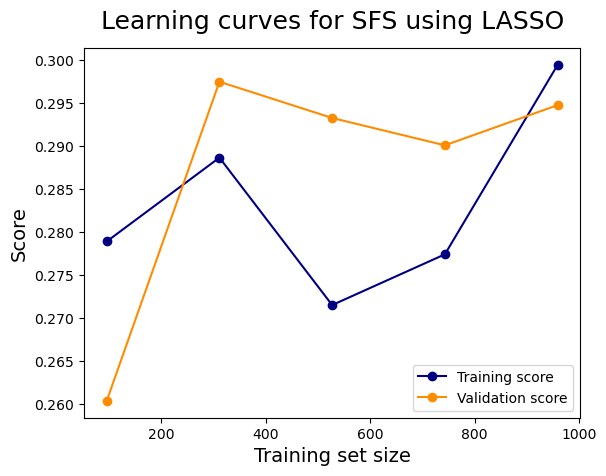

In [90]:
#Plot Learning curve
sfs_lasso_train_sizes, sfs_lasso_train_scores, sfs_lasso_test_scores = learning_curve(
        sfs_lasso_pipe,
        X_train,
        y_train
    )
sfs_lasso_train_scores_mean = np.mean(sfs_lasso_train_scores, axis=1)
sfs_lasso_test_scores_mean = np.mean(sfs_lasso_test_scores, axis=1)

plt.plot(sfs_lasso_train_sizes, sfs_lasso_train_scores_mean, label="Training score", color="navy", marker='o')
plt.plot(sfs_lasso_train_sizes, sfs_lasso_test_scores_mean, label="Validation score", color="darkorange", marker='o')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for SFS using LASSO', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

## RFE using Lasso to select 4 features

In [70]:
# Create a Lasso model
rfe_lasso = Lasso(alpha=0.1)  # You can adjust alpha as needed

# Create the RFE selector with Lasso
rfe = RFE(estimator=rfe_lasso, n_features_to_select=4)

# Create a pipeline with a scaler and RFE
rfe_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', rfe)
])

# Fit RFE selector to the data
rfe_pipe.fit(X_train, y_train)

# Get selected features
rfe_selected_features_mask = rfe_pipe.named_steps['rfe'].support_
rfe_selected_features = X_train.columns[rfe_selected_features_mask]

# Print selected features
print("Selected features:", rfe_selected_features)

Selected features: Index(['volatile acidity', 'pH', 'sulphates', 'alcohol'], dtype='object')


In [71]:
# Get the coefficients from the Lasso model
rfe_lasso_coef = rfe_pipe.named_steps['rfe'].estimator_.coef_

# Create a DataFrame to display the coefficients with their corresponding feature names
rfe_coef_df = pd.DataFrame({'Selected Feature': rfe_selected_features, 'rfe_lasso_Coefficient': rfe_lasso_coef})

In [74]:
rfe_coef_df_sorted = rfe_coef_df.reindex(rfe_coef_df['rfe_lasso_Coefficient'].abs().sort_values(ascending=False).index)

In [76]:
# Make predictions
rfe_train_preds = rfe_pipe.predict(X_train)
rfe_test_preds = rfe_pipe.predict(X_test)

# Calculate rfe MSE
rfe_lasso_train_mse = mean_squared_error(y_train, rfe_train_preds)
rfe_lasso_test_mse = mean_squared_error(y_test, rfe_test_preds)

In [78]:
rfe_lasso_train_mse, rfe_lasso_test_mse

(0.46539407696658114, 0.43223065709806036)

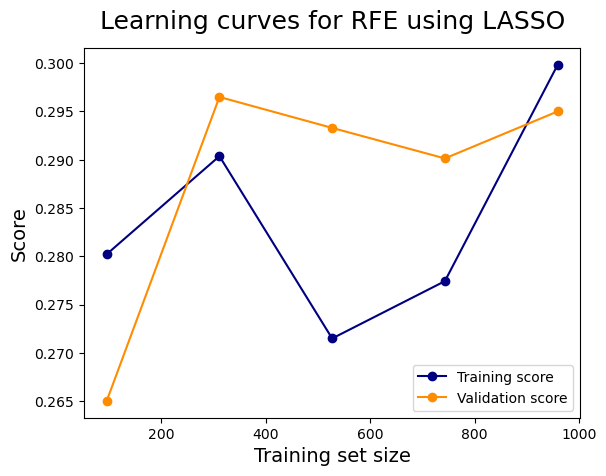

In [91]:
#Plot Learning curve
rfe_lasso_train_sizes, rfe_lasso_train_scores, rfe_lasso_test_scores = learning_curve(
        rfe_pipe,
        X_train,
        y_train
    )
rfe_lasso_train_scores_mean = np.mean(rfe_lasso_train_scores, axis=1)
rfe_lasso_test_scores_mean = np.mean(rfe_lasso_test_scores, axis=1)

plt.plot(rfe_lasso_train_sizes, rfe_lasso_train_scores_mean, label="Training score", color="navy", marker='o')
plt.plot(rfe_lasso_train_sizes, rfe_lasso_test_scores_mean, label="Validation score", color="darkorange", marker='o')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for RFE using LASSO', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [81]:
# Create a dictionary to store the MSEs
mse_dict = {
    'Method': ['Ridge', 'SFS Lasso', 'RFE Lasso'],
    'Train MSE': [ridge_train_mse, sfs_lasso_train_mse, rfe_lasso_train_mse],
    'Test MSE': [ridge_test_mse, sfs_lasso_test_mse, rfe_lasso_test_mse]
}

# Create a DataFrame from the dictionary
mse_df = pd.DataFrame(mse_dict)

# Print the DataFrame
mse_df

,Method,Train MSE,Test MSE
0,Ridge,0.428124,0.389630
1,SFS Lasso,0.465394,0.432231
2,RFE Lasso,0.465394,0.432231


In [82]:
rfe_coef_df_sorted

,Selected Feature,rfe_lasso_Coefficient
3,alcohol,0.263593
0,volatile acidity,-0.143862
2,sulphates,0.027303
1,pH,-0.000000


In [86]:
# Create a dictionary to store the MSEs
alpha_dict = {
    'Method': ['Ridge', 'Lasso'],
    'Best alpha': [ridge_best_alpha, best_alpha_lasso]
}

# Create a DataFrame from the dictionary
alpha_df = pd.DataFrame(alpha_dict)

# Print the DataFrame
alpha_df

,Method,Best alpha
0,Ridge,75.431201
1,Lasso,0.013257
